In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from pandas.api.indexers import FixedForwardWindowIndexer
from matplotlib.ticker import PercentFormatter

import jax
import jax.numpy as np
from jax.numpy import array as arr
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp
from jax.scipy.special import expit as logistic
from jax.scipy.special import logit
from jax.scipy.special import gammaln
from jax.scipy import stats

import numpyro as pn
from numpyro import sample
from numpyro import deterministic
import numpyro.distributions as dist
from numpyro.distributions import Normal as Norm
from numpyro.distributions import Exponential as Ex
from numpyro.distributions import Poisson as Pois
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import print_summary, hpdi

from scipy.interpolate import BSpline
import numpy as num ##scipy needs actual numpy

import warnings
import dill

/Users/sasha/miniconda3/envs/sero/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 02 2024

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.14.0

seaborn   : 0.12.2
numpy     : 1.25.0
numpyro   : 0.10.1
jax       : 0.3.17
matplotlib: 3.7.1
arviz     : 0.12.1
pandas    : 1.4.4
dill      : 0.3.6

Watermark: 2.3.1



In [3]:
%config InlineBackend.figure_formats = ["svg"]
plt.style.use("default")
sns.set_theme(context='paper', style="ticks", font_scale=1.25)
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)

## set numpyro platform to cpu because I don't have the right kind of gpu
pn.set_platform("cpu")

## tell numpyro to use mult cpu cores (this many chains can run in parallel)
pn.set_host_device_count(4)

## jax wants float32's by default, but sometimes it helps to use higher-precision floats:
HIPREC = True

if HIPREC: 
    pn.enable_x64()
    fl = np.float64
    toint = np.int64
else:
    fl = np.float32
    toint = np.int32

## for jax's RNG
def key_gen(seed = random.PRNGKey(8927)):
    def key():
        nonlocal seed
        seed, new_key = random.split(seed)
        return new_key
    return key

key = key_gen()


In [4]:
def store(obj, name):
    with open(f'{name}.dill', 'wb') as f:
        dill.dump(obj, f)

def load(name):
    with open(f'{name}.dill', 'rb') as f:
        return dill.load(f)

#def pdz(series):
#    return (series - series.mean()) / series.std()

## resizes an array, repeating the last element if needed
#def resize(x, new_size):
#    return np.concatenate([x,np.repeat(x[-1], max(0,new_size-len(x)))])[:new_size]


In [5]:
def SECIR_ode(y, t, p):
    S, E, C, I, R, CumC, CumI = y[0], y[1], y[2], y[3], y[4], y[5], y[6]
    alpha, beta, mu, gamma1, gamma2, theta = p[0], p[1], p[2], p[3], p[4], p[5]
    N = S + E + C + I + R
    S_dot = -S*C*alpha*beta/N - S*I*beta/N
    E_dot = S*C*alpha*beta/N + S*I*beta/N - E*mu
    C_dot = E*mu*(1-theta) - C*gamma1
    I_dot = E*mu*theta - I*gamma2
    R_dot = C*gamma1 + I*gamma2
    CumC_dot = E*mu*(1-theta)
    CumI_dot = E*mu*theta
    return np.stack([S_dot, E_dot, C_dot, I_dot, R_dot, CumC_dot, CumI_dot])

In [6]:
## have to do time-variable ODE params this way
##  then, jax.lax.scan(onestep, y0, p_t)[1]
## scan() will pass each param set in p_t to onestep() and collect the results in return value [1]
## p_t must have time as the first axis
def onestep(prev, p):
    next = odeint(SECIR_ode, prev, arr([0.,1.]), p, rtol=1e-6, atol=1e-6, mxstep=2000)#rtol=1e-6, atol=1e-6, mxstep=1000)#rtol=1e-5, atol=1e-5, mxstep=500)
    return next[1], next[1]

In [7]:
## this way works fine by itself, but not inside the sampler
##  for some incomprehensible reason
def SECIR_ode_t(y, t, p):
    S, E, C, I, R, CumC, CumI = y[0], y[1], y[2], y[3], y[4], y[5], y[6]
    idx = toint(t)
    alpha, beta, mu, gamma1, gamma2, theta = p[0][idx], p[1][idx], p[2][idx], p[3][idx], p[4][idx], p[5][idx]
    N = S + E + C + I + R
    S_dot = -S*C*alpha*beta/N - S*I*beta/N
    E_dot = S*C*alpha*beta/N + S*I*beta/N - E*mu
    C_dot = E*mu*(1-theta) - C*gamma1
    I_dot = E*mu*theta - I*gamma2
    R_dot = C*gamma1 + I*gamma2
    CumC_dot = E*mu*(1-theta)
    CumI_dot = E*mu*theta
    return np.stack([S_dot, E_dot, C_dot, I_dot, R_dot, CumC_dot, CumI_dot])

In [8]:
## R = (th)(b / g2) + (a)(1-th)(b / g1)

## R*g1*g2 =  b * [ th*g1 + a(1-th)*g2 ] 

## b = R*g1*g2 / [ th*g1 + a(1-th)*g2 ]

def calc_R(b, g1, g2, th, a = 1.0):
    return th*(b / g2) + a*(1.0-th)*(b / g1)

def calc_b(R, g1, g2, th, a = 1.0):
    return R*g1*g2 / ( th*g1 + a*(1.0-th)*g2 )

In [9]:

def pred_daily_samp(post, modeldict, n_draws, full_reporting=False):
    res = []
    psize = modeldict['Population']
    nsamples = post['sigma'].shape[0]
    samp_ids = jax.random.permutation(key(),nsamples,independent=True)[:n_draws]
    for s in samp_ids:
        b0, th0 = post['beta'][s], post['theta'][s]
        if full_reporting:
            th0 = np.ones_like(th0)
        a0,mu0,g1,g2 = post['alpha'][s], post['mu'][s], post['gamma1'][s], post['gamma2'][s]
        e0,i0,c0 = post['e0'][s], post['i0'][s], post['c0'][s]
        y0 = arr([psize - (e0 + c0 + i0), e0, c0, i0, c0*0.0, c0, i0])
        p_t = np.stack([a0 , b0 , mu0 , g1, g2, th0]).T #time first
        pred_vals = jax.lax.scan(onestep, y0, p_t)[1]
        pred_daily = np.diff(pred_vals[:,6], prepend=0)
        res.append(pred_daily)

    return np.stack(res)


In [10]:
def df_samples(post, modeldict, real_R_calc = False):
    df = pd.DataFrame({"Date":modeldict["Dates"]})

    if real_R_calc:
        R_t = calc_R(post['beta'], post['gamma1'], post['gamma2'], post['theta'], post['alpha'])
    else:
        R_t = post['beta'] / post['gamma2']

    df["R_t"] = R_t.mean(0)
    ci = hpdi(R_t)
    df["R_t_lower95"] = ci[0,:]
    df["R_t_upper95"] = ci[1,:]
    df['DailyCases'] = modeldict['DailyCases']
    df['theta'] = post['theta'].mean(0)
    cols = []
    pred_daily = pred_daily_samp(post, modeldict, 50)
    for i,v in enumerate(pred_daily):
        colname = 'sim'+str(i)
        df[colname] = v
        cols.append(colname)

    return df, cols

In [11]:
## data from MD dept of health
MD_cases = pd.read_csv("MDCOVID19_TotalCasesStatewide.csv")
MD_cases["daily"] = np.diff(MD_cases["Count_"].values, prepend=0)

## forward-looking moving average, because reporting is always in the future
f7_indexer = FixedForwardWindowIndexer(window_size=7)

#MD_cases["MD_CumCases"] = MD_cases["Count_"].rolling(f7_indexer, min_periods=1).mean()
MD_cases["MD_DailyCases"] = MD_cases["daily"].rolling(f7_indexer, min_periods=1).mean()
MD_cases["Date"] = MD_cases["DATE"].apply(lambda x: str.split(x)[0].replace('/','-'))
MD_cases = MD_cases.loc[0:453,["Date","MD_DailyCases"]]
MD_cases

Date  MD_DailyCases
0    2020-03-04       1.285714
1    2020-03-05       1.714286
2    2020-03-06       1.285714
3    2020-03-07       1.714286
4    2020-03-08       3.285714
..          ...            ...
449  2021-05-27     168.857143
450  2021-05-28     157.000000
451  2021-05-29     142.285714
452  2021-05-30     134.714286
453  2021-05-31     114.000000

[454 rows x 2 columns]

In [12]:
bad_MD = MD_cases["MD_DailyCases"] < 0.0
MD_cases.loc[bad_MD,"MD_DailyCases"] = np.nan
md_data_ok = np.logical_not(bad_MD.values)
bad_MD.sum()

0

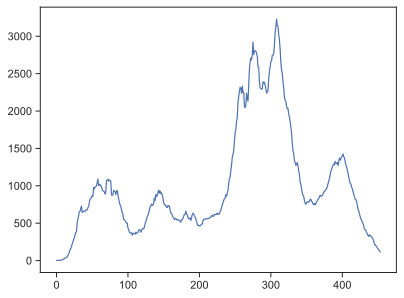

In [13]:
plt.plot(MD_cases["MD_DailyCases"]);

In [ ]:
## serology data from JHU
sero_results = pd.read_csv('TestResultsByDateWithWeights.csv')
## overall weight of each data point
sero_results['wt'] = sero_results['hwght'] * sero_results['psuweight']
sero_results['weight'] = (sero_results["wt"] / sero_results["wt"].mean())
sero_results['dt'] = pd.to_datetime(sero_results['Specimen_collection_date']).apply(str)
sero_results['Date'] = sero_results['dt'].apply(lambda x: str.split(x)[0].replace('/','-'))
## match date index to case data
date_idxs = pd.DataFrame({"Date":MD_cases["Date"], "date_idx":range(len(MD_cases["Date"]))})
sero_results = sero_results.merge(date_idxs,how="left",on="Date")

## assume 14 days from symptom onset to seroconversion
## map each sero result to the infection count from 14 days prior
sero_results["date_idx"] = sero_results["date_idx"] - 14

sero_results = sero_results[["Date","date_idx","seropos","weight"]]
sero_results = sero_results.sort_values(by="date_idx")
sero_results

In [15]:
## MD deaths from dept health
dd = pd.read_csv('MDCOVID19_TotalConfirmedDeathsByDateOfDeath.csv')
dd['Date'] = dd['DATE'].apply(lambda x: str.split(x)[0].replace('/','-'))
MD_deaths = MD_cases[["Date"]].merge(dd[["Date","Count_"]],how="outer",on="Date").fillna(0.0)
## forward-looking moving average, because reporting is always in the future
MD_deaths['daily_deaths']  = MD_deaths["Count_"].rolling(f7_indexer, min_periods=1).mean()
MD_deaths = MD_deaths[["Date","daily_deaths"]]
MD_deaths.set_index('Date',verify_integrity=True,inplace=True)
MD_deaths

daily_deaths
Date                    
2020-03-04      0.000000
2020-03-05      0.000000
2020-03-06      0.000000
2020-03-07      0.000000
2020-03-08      0.000000
...                  ...
2022-11-13      2.000000
2022-11-14      2.000000
2022-11-15      1.666667
2022-11-16      0.500000
2022-11-17      0.000000

[989 rows x 1 columns]

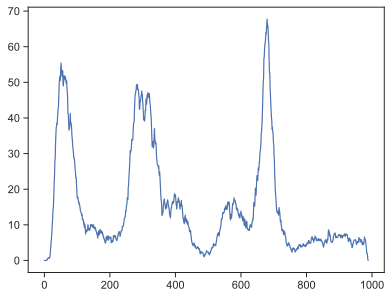

In [16]:
plt.plot(MD_deaths['daily_deaths'].values);

In [17]:
daily_obs = arr(MD_cases['MD_DailyCases'].values)
ts = np.arange(fl(len(daily_obs)))
daily_ok_raw = daily_obs[md_data_ok]
totalI = np.sum(daily_ok_raw)

In [18]:
## splines
## evenly spaced basis splines, approx 14 day period
n_spline_periods = 32 
deg = 2
knots = num.linspace(0., ts.max(), n_spline_periods+1-deg)
padded_knots = num.pad(knots, (deg,deg), mode='edge')
B = BSpline(padded_knots, num.identity(len(knots)+deg-1), deg)(ts)

In [19]:
MD_dict = {
    'tdom': ts,
    'Dates': MD_cases["Date"].values,
    'initInfected': 1.0, ## I compartment only; C compartment estimated by model
    'Population': 6177224.0, ## from US census ## 6045680.0, ## from ???
    'alpha': np.repeat(1.0, len(ts)),
    'mu': np.repeat(0.15, len(ts)), ## incubation 6.65 days ref Wu 2022
    'gamma1': np.repeat(0.2, len(ts)), ## infectiousness period ~5 days ref Bi 2020 and Giardina 2021
    'gamma2': np.repeat(0.2, len(ts)),
    'DailyCases': daily_obs,
    'totalI': totalI,
    'daily_ok': daily_ok_raw / totalI,
    'Nt': len(daily_ok_raw),
    'knots': arr(knots),
    'spline': arr(B),
    'nperiods': n_spline_periods,
    'sero_date_idxs': arr(sero_results["date_idx"].values),
    'seropos': arr(sero_results["seropos"].values),
    'sero_weights': arr(sero_results["weight"].values)
}

ok_for_jax = md_data_ok

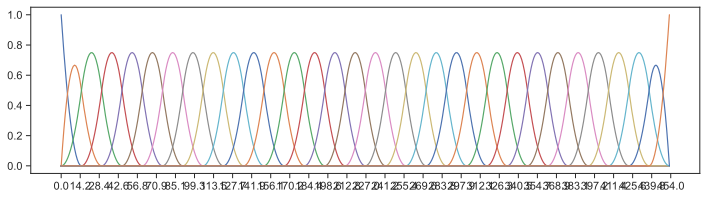

In [20]:
## the splines:
_,ax = plt.subplots(figsize=[12,3])
ax.set_xticks(np.linspace(0,len(MD_dict['tdom']),MD_dict['nperiods']+1))
for i in range(MD_dict['nperiods']):
    plt.plot(MD_dict['spline'][:,i])

In [20]:
#rev_L = 202.2
#rev_k = 2.32
#rev_curve = np.flip(np.exp(-np.power( np.arange(300.) /rev_L, rev_k)))
#rev_curve

In [ ]:
#rev_mat = np.flip( jax.lax.map(lambda i: np.roll(rev_curve,i), -1*np.arange(300)) , axis=0 ) * np.tri(300)
#rev_mat

In [ ]:
## priors

In [ ]:
samp = dist.Beta(0.20,2.0).sample(key(),(10000,))
az.plot_kde(samp, quantiles=[0.25,0.5,0.75]);
print(hpdi(samp), np.mean(samp), np.median(samp))


In [ ]:
samp = dist.Gamma(3.0,0.1).sample(key(),(10000,))
az.plot_kde(samp, quantiles=[0.25,0.5,0.75]);
print(hpdi(samp), np.mean(samp), np.median(samp))


In [ ]:
samp = dist.LogNormal(0.0,0.7071).sample(key(),(10000,))
az.plot_kde(samp, quantiles=[0.25,0.5,0.75]);
print(hpdi(samp), np.mean(samp), np.median(samp), np.std(samp), sum(samp<0.5), sum(samp>2.0))

In [ ]:
_,ax=plt.subplots()
ax.set(ylim=(0,1))
th_max = 0.6
th0s = arr([-2.0,-4.0])
shapes = arr([0.5,1.0,2.0])
dth_dt = 0.05
for th0 in th0s:
    for shape in shapes:
        #ax.plot(MD_dict['tdom'], th_max * logistic(th0 + MD_dict['tdom']*dth_dt))
        ax.plot(MD_dict['tdom'], th_max * np.power(1.0 + np.exp(-th0 - MD_dict['tdom']*dth_dt), -shape) )


In [ ]:
beta_conc = 5.
beta_n = 1.0 + 0.2 * (0.0 + beta_conc)
samp = 5.0 * dist.Gamma(beta_n,beta_conc).sample(key(),(50000,))
az.plot_kde(samp, quantiles=[0.25,0.5,0.75]);
print(hpdi(samp,prob=0.95), np.mean(samp), np.median(samp), np.std(samp), beta_n)
#x,y = az.kde(samp)
#print(x[np.argmax(y)])

In [5]:
logit(0.1)

DeviceArray(-2.1972246, dtype=float32, weak_type=True)

In [21]:
##
## prior for beta is set such that R is roughly centered around 1 while still allowing values > 4
## if alpha or gamma changes, relationship btw R and beta changes
## -- set beta_prior_exp to a value that gives R = 1
##
def model_wrev(mdict, data_ok, beta_prior_exp = 0.2):

    alpha = deterministic("alpha", mdict['alpha'])
    mu = deterministic("mu", mdict['mu'])
    gamma2 = deterministic("gamma2", mdict['gamma2'])
    gamma1 = deterministic("gamma1", mdict['gamma1'])

    ## gamma(2,5) prior ## (ref Karimizadeh 2023)
    beta_conc = 5.0 #9.0 
    beta_n = 1.0 + beta_prior_exp * beta_conc #1.0 + beta_prior_exp * (1.0 + beta_conc)

    #using basis splines for beta
    beta_mean = sample("beta_mean", dist.Gamma(beta_n,beta_conc), sample_shape=(mdict['nperiods'],))
    beta = deterministic("beta", mdict['spline'] @ beta_mean)
    
    ## generalized logistic for theta
    th0 = sample("th0", Norm(logit(0.1), 4.0))
    #th_min = sample("th_min", dist.Beta(0.20,2.0))
    dth_dt = sample("dth_dt", dist.HalfNormal(0.2)) ##constrain to be increasing
    th_max = sample("th_max", dist.Beta(2.0,2.0))
    #th_x0 = sample("th_x0", dist.Gamma(3.0,0.1))
    #th_shape = sample("th_shape", dist.LogNormal(0.0,0.7))
    theta = deterministic("theta", th_max * logistic(th0 + mdict['tdom']*dth_dt))
    #theta = deterministic("theta", th_min + (th_max - th_min) * logistic(dth_dt * (mdict['tdom'] - th_x0 )) )
    #theta = deterministic("theta", th_max * np.power(1.0 + np.exp(-th0 - mdict['tdom']*dth_dt), -th_shape))

    i0 = deterministic("i0", mdict['initInfected'])
    e0 = deterministic("e0", 0.0)
    ## c0 should be approx i0/theta
    #c0 = deterministic("c0", i0 / theta[0])
    log_init = sample("log_init", Norm(4.0, 4.0)) ##helps sampling to leave c0 free
    c0 = deterministic("c0", np.exp(log_init))
    psize = mdict['Population']
    y0 = np.stack([psize - (e0 + i0 + c0), e0, c0, i0, 0.0, c0, i0])

    p_t = np.stack([alpha, beta, mu, gamma1, gamma2, theta]).T #transpose so time is first axis
    pred_vals = jax.lax.scan(onestep, y0, p_t)[1] #see explanation in onestep() above
    pred_daily = np.diff(pred_vals[:,6], prepend=0)
    pred_ok = pred_daily[data_ok] / mdict['totalI']

    ## seroreversion (time from seroconversion): Weibull shape 2.32, scale 202.20 (Brazeau et al 2022)
    #rev_k = sample("rev_k", dist.Gamma(9.28,4.0)) # Norm(2.32, 1.0))
    rev_k = deterministic("rev_k", 2.32) ## assume fixed? (1 = exponential dist)
    rev_L = sample("rev_L", Norm(202.20, 10.0))
    ## if using non-fixed k, parameterize using mean instead of scale (easier priors)
    #rev_mean = sample("rev_mean", Norm(179.15, 20.0))
    #rev_L = np.maximum(1e-6, rev_mean / np.exp(gammaln(1.0 + 1.0 / rev_k)) )

    ## precompute reversion curves for each day in the testing period
    rev_curve = np.flip(np.exp(-np.power( np.arange(300.) / rev_L, rev_k)))
    rev_mat = np.flip( jax.lax.map(lambda i: np.roll(rev_curve,i), -1*np.arange(300)) , axis=0 ) * np.tri(300)
    ## p detectable as function of time (days)
    true_p_inf = mdict["DailyCases"][:300] / (theta[:300] * psize)
    detectable_by_day = np.nansum(true_p_inf * rev_mat , axis=1)

    ## p = detectable_by_day[MD_dict["sero_date_idxs"]]
    ## obs = MD_dict["seropos"]
    ## weights = MD_dict["sero_weights"]
    with pn.plate("sero_data", len(MD_dict["seropos"])), pn.handlers.scale(scale=MD_dict["sero_weights"]):
        sample("sero", dist.Bernoulli(detectable_by_day[MD_dict["sero_date_idxs"]]), obs=MD_dict["seropos"])

    sigma = sample("sigma", dist.Exponential(1.0))
    nu = sample("xnu", dist.Gamma(4.0,1.0)) ## df should be < 10 for robustness
    #nu = 5.0 ## fixed for now
    #sample("daily", dist.StudentT(nu, pred_ok, sigma), obs=mdict['daily_ok'])
    eps = 1.0 / psize
    sample("daily", dist.StudentT(nu, np.log(eps+pred_ok), sigma), obs=np.log(eps+mdict['daily_ok']))


In [22]:
run_models = False

In [22]:
runs_wrev = []

if run_models:
    dat = {'mdict': MD_dict, 'data_ok': ok_for_jax}
    runs_wrev.append( 
        MCMC(NUTS(model_wrev, 
        #target_accept_prob=0.88, dense_mass=True),# init_strategy=pn.infer.init_to_sample), 
        #target_accept_prob=0.9, dense_mass=True),# init_strategy=pn.infer.init_to_sample), 
        target_accept_prob=0.9, dense_mass=True, init_strategy=pn.infer.init_to_sample), 
        #target_accept_prob=0.92, dense_mass=True, init_strategy=pn.infer.init_to_sample), 
        #num_warmup=5000, num_samples=5000, num_chains=6)
        num_warmup=2500, num_samples=5000, num_chains=4)
        #num_warmup=1000, num_samples=500, num_chains=6)
    )
    runs_wrev[-1].run(key(), **dat)

Compiling.. :   0%|          | 0/7500 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/7500 [00:10<?, ?it/s]





Running chain 0:  10%|█         | 750/7500 [16:41<2:24:18,  1.28s/it]


Running chain 0:  15%|█▌        | 1125/7500 [23:01<2:03:16,  1.16s/it]


Running chain 0:  25%|██▌       | 1875/7500 [35:45<1:40:15,  1.07s/it]


Running chain 0:  35%|███▌      | 2625/7500 [48:13<1:24:00,  1.03s/it]


Running chain 0:  40%|████      | 3000/7500 [55:11<1:19:28,  1.06s/it]


Running chain 0:  50%|█████     | 3750/7500 [1:08:54<1:07:33,  1.08s/it]


Running chain 0:  55%|█████▌    | 4125/7500 [1:15:53<1:01:23,  1.09s/it]


Running chain 0:  60%|██████    | 4500/7500 [1:22:48<54:49,  1.10s/it]  


Running chain 0:  65%|██████▌   | 4875/7500 [1:29:41<48:01,  1.10s/it]


Running chain 0:  70%|███████   | 5250/7500 [1:36:32<41:08,  1.10s/it]


Running chain 0:  75%|███████▌  | 5625/7500 [1:44:38<36:10,  1.16s/it]


Running chain 0:  80%|████████  | 6000/7500 [1:52:03<29:08,  1.17s/it

In [23]:
#store(runs_wrev[0],'wrev_5000x4_0')
runs_wrev = [load("wrev_5000x4_0")]

In [24]:
use_model = runs_wrev[0]
model_var_names = ['th0', 'th_max', 'dth_dt', 'c0', 'xnu', 'sigma', 'rev_L', "log_init"]
#model_var_names = ['th_min', 'th_max', 'th_x0', 'dth_dt', 'c0', 'xnu', 'sigma', 'rev_L']
#model_var_names = ['th0', 'th_max', 'dth_dt', "log_init", 'c0', 'xnu', 'sigma', 'rev_mean', 'rev_k']
#model_var_names = ['th0', 'th_max', 'dth_dt', 'th_shape', 'c0', 'xnu', 'sigma', 'rev_L', "log_init"]


In [24]:
az.summary(use_model,var_names=['th0', 'th_max', 'dth_dt', 'c0', 'xnu', 'sigma', 'rev_L'])

mean        sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
th0       -4.008     1.159   -6.473    -1.954      0.038    0.028     986.0   
th_max     0.321     0.043    0.264     0.409      0.002    0.002     691.0   
dth_dt     0.188     0.042    0.112     0.269      0.001    0.001    1020.0   
c0      1907.678  3818.040   17.239  6356.916    103.568   73.249    1324.0   
xnu        4.076     0.943    2.475     5.868      0.010    0.007    9656.0   
sigma      0.050     0.003    0.043     0.056      0.000    0.000    9561.0   
rev_L    202.509     9.919  184.056   221.376      0.101    0.071    9705.0   

        ess_tail  r_hat  
th0       1005.0    1.0  
th_max     466.0    1.0  
dth_dt    1131.0    1.0  
c0        1480.0    1.0  
xnu      11769.0    1.0  
sigma    10951.0    1.0  
rev_L    11207.0    1.0

In [4]:

gshape = np.exp(gammaln(1.0 + 1.0 / 2.32))
arr([202.509 * gshape, 184.056 * gshape, 221.376 * gshape])


DeviceArray([179.42467, 163.07516, 196.14099], dtype=float32)

In [34]:
az.plot_trace(use_model,var_names=['th0', 'th_max', 'dth_dt', 'log_init', 'xnu', 'sigma', 'rev_L']);

In [ ]:
## drop a chain
#az_obj = az.from_numpyro(use_model)
#az.plot_trace(az_obj.sel(chain=[0]),var_names=model_var_names);
#az_obj = az_obj.sel(chain=[2,3,4,5])
#az.summary(az_obj,var_names=model_var_names)
#ds_post = az_obj.posterior.stack({"sample": ["chain","draw"]}).transpose()
#post = {k:arr(ds_post[k].values) for k in ds_post.keys()}

In [25]:
post = use_model.get_samples()

In [26]:

df, sim_cols = df_samples(post,MD_dict)


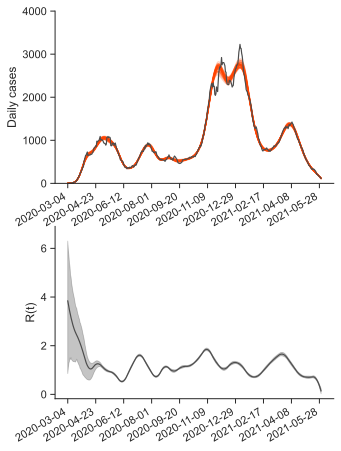

In [60]:
fig, ax = plt.subplots(2,1,figsize=[5,7],dpi=300)
for c in sim_cols:
    ax[0].plot(df[c], color='orangered', alpha=0.25)

sns.lineplot(ax=ax[0],data=df,x="Date",y="DailyCases",color="0.3")
sns.lineplot(ax=ax[1],data=df,x="Date",y="R_t",color="0.3")
sns.despine()

ax[1].fill_between(df["Date"],df["R_t_lower95"],df["R_t_upper95"],alpha=0.33,color='0.3')
ax[0].set(ylim=(0,4000), xlabel=None, ylabel='Daily cases')
ax[1].set(ylim=(-0.18,6.9), xlabel=None, ylabel='R(t)')
fig.subplots_adjust(hspace=0.25)

for x in ax:
    x.set_xticks(x.get_xticks()[::50]);
    x.set_xticklabels(x.get_xticklabels(), rotation=30, horizontalalignment='right');

plt.savefig("wrev sero_Rt.png", bbox_inches='tight',dpi=300)


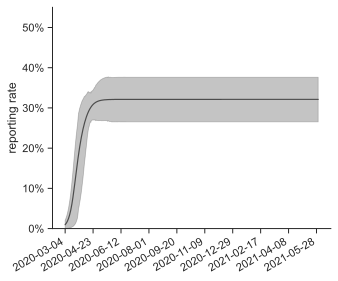

In [32]:
fig, ax = plt.subplots(figsize=[5,4],dpi=300)
sns.lineplot(ax=ax,data=df,x="Date",y="theta",color="0.3")
sns.despine()

ax.yaxis.set_major_formatter(PercentFormatter(1))

ci = hpdi(post['theta'])
ax.fill_between(df["Date"],ci[0,:],ci[1,:],alpha=0.33,color="0.3")
ax.set(ylim=(0,0.55),ylabel='reporting rate',xlabel=None)
ax.set_xticks(ax.get_xticks()[::50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

plt.savefig("wrev sero_theta.png",bbox_inches='tight',dpi=300)

In [62]:
x = pred_daily_samp(post,MD_dict,2000)
pred_samp = x.mean(0)
obs = MD_dict['DailyCases']
resid = pred_samp - obs
## pseudo-R2 (there are better measures of this)
1.0 - np.var(resid) / np.var(obs)

DeviceArray(0.98167618, dtype=float64)

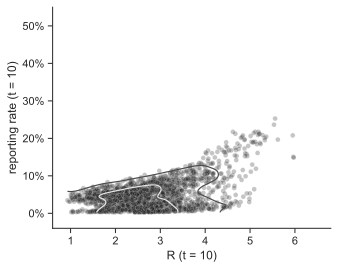

In [27]:
t = 10
fig,ax=plt.subplots(figsize=[5,4],dpi=300)

sns.scatterplot(data=pd.DataFrame(data={"beta":5.0*post['beta'][0:2000,t], "theta":post['theta'][0:2000,t]}),
    x="beta",y="theta",alpha=0.25,color="0.1")
sns.despine()

ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.set(xlim=(0.6,6.8), ylim=(-0.04,0.55), xlabel=f'R (t = {t})' ,ylabel=f'reporting rate (t = {t})')
az.plot_kde(5.0*post['beta'][0:2000,t], post['theta'][0:2000,t], hdi_probs=[0.5,0.9], ax=ax, 
    contourf_kwargs={'alpha':0}, contour_kwargs={'colors':["0.9","0.3"]})

plt.savefig("wrev sero_joint.png",bbox_inches='tight',dpi=300)


In [34]:
pred_total_daily = pred_daily_samp(post, MD_dict, 5000, True)

In [35]:
df["inf_total"] = pred_total_daily.mean(0)
ci = hpdi(pred_total_daily)
df["inf_total_L"] = ci[0]
df["inf_total_H"] = ci[1]

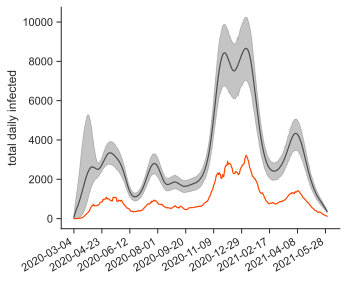

In [94]:
fig, ax = plt.subplots(figsize=[5,4],dpi=300)
sns.lineplot(ax=ax,data=df,x="Date",y="inf_total",color="0.3")
sns.lineplot(ax=ax,data=df,x="Date",y="DailyCases",color="orangered")
sns.despine()

ax.fill_between(df["Date"],df["inf_total_L"],df["inf_total_H"],alpha=0.33,color="0.3")
ax.set(ylabel='total daily infected',xlabel=None)
ax.set_xticks(ax.get_xticks()[::50]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

plt.savefig("wrev sero_total_infected.png",bbox_inches='tight',dpi=300)


In [ ]:
df = df.join(pd.Series(arr(MD_deaths.loc['2020-03-04':,'daily_deaths'])).rename("daily_deaths"))
df["true_daily"] = df["DailyCases"] / df["theta"]

In [ ]:
lag = 14
plt.plot(df["true_daily"].values[:-lag]);
plt.plot(df["DailyCases"].values[:-lag]);
plt.plot(60 * df["daily_deaths"].values[lag:]);

In [36]:
daily_deaths = arr(MD_deaths.loc['2020-03-04':,'daily_deaths'])

In [37]:

nb_r = 5.6
nb_p = 0.2857
xlen = daily_deaths.shape[0]
p_dist = stats.nbinom.pmf(np.arange(xlen), nb_r, nb_p).round(6)

future_deaths = arr([np.nansum(daily_deaths * p_dist), 
    *[np.nansum(daily_deaths[i:] * p_dist[:-i]) for i in range(1,xlen-60)]])

future_deaths = future_deaths[:MD_dict['tdom'].shape[0]]


In [38]:
prob_fatality = future_deaths / pred_total_daily
ci = hpdi(prob_fatality)

In [39]:
df = df.join(pd.DataFrame({"prob_fatality":prob_fatality.mean(0), "prob_fatality_L":ci[0], "prob_fatality_H":ci[1]}))

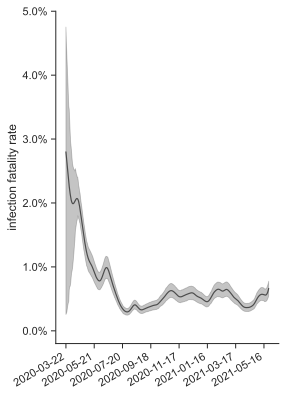

In [40]:

## very noisy at beginning
df_plot = df.iloc[18:-5,:]

fig, ax = plt.subplots(figsize=[4,6],dpi=300)
sns.lineplot(ax=ax,data=df_plot,x="Date",y="prob_fatality",color="0.3")
sns.despine()

ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.fill_between(df_plot["Date"],df_plot["prob_fatality_L"],df_plot["prob_fatality_H"],alpha=0.33,color="0.3")
ax.set(ylabel='infection fatality rate',xlabel=None,ylim=(-0.002,0.05))
ax.set_yticks(ax.get_yticks()[1::1]);
ax.set_xticks(ax.get_xticks()[::60]);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

plt.savefig("wrev prob infection_fatality.png",bbox_inches='tight',dpi=300)


In [59]:
df_plot[["Date","prob_fatality"]].iloc[163:,:]

Date  prob_fatality
181  2020-09-01       0.003313
182  2020-09-02       0.003342
183  2020-09-03       0.003376
184  2020-09-04       0.003412
185  2020-09-05       0.003448
..          ...            ...
444  2021-05-22       0.005738
445  2021-05-23       0.005871
446  2021-05-24       0.006059
447  2021-05-25       0.006307
448  2021-05-26       0.006618

[268 rows x 2 columns]

In [66]:
ifr_after_sep = prob_fatality[:,163+18:-5].mean(1)

In [74]:
print(100 * ifr_after_sep.mean(), "%")
print(100 * hpdi(ifr_after_sep,prob=0.95), "%")

0.5143472763646953 %
[0.42910627 0.6787989 ] %
